# Trying to read from 2D Abaqus

lets see

In [1]:
from six import iterkeys, iteritems
import re
import csv
import numpy as np
import meshconvert as mc

import xml_writer

# Open file Abaqus file
file = open('Geometry_modified.inp', 'r')
csv_file = csv.reader(file, delimiter=',', skipinitialspace=True)

class State:
    Init, Unknown, Invalid, ReadHeading, ReadNodes, ReadCells, \
        ReadNodeSet, ReadCellSet, ReadSurfaceSet = list(range(9))

node_set_name = None
node_set_name = None

# Set intial state state
state = State.Init

# Dictionary of nodes (maps node id to coordinates)
nodes = {}

# Dictionary of elements (maps cell id to list of cell nodes)
elems = {}

# Lists of nodes for given name (key)
node_sets = {}

# Lists of cells for given name (key)
cell_sets = {}

# Lists of surfaces for given name (key) in the format:
# {'SS1': [set(['SS1_S1', 'S1']), set(['SS1_S4', 'S4'])]},
# where SS1 is the name of the surface, SS1_S1 is the name of the
# cell list whose first face is to be selected, ...
surface_sets = {}

#handler = mc.XmlHandler('Geometry2D.xml')

In [2]:
def _read_heading(l):
    return l[0].strip()


def _read_part_name(l):

    if (len(l) < 2): print("Ooops, length problem.")
    part_names = l[1].split('=')

    if (len(part_names) < 2): print("Ooops, part names length problem.")
    return part_names[1].strip()
def _create_node_list_entry(node_sets, l):

    # Check for node set name
    node_set_name = None
    if len(l) == 2:
        set_data = l[1].split('=')
        assert len(set_data) == 2, "wrong list length"
        if set_data[0].lower() == "nset":
            node_set_name = set_data[1]
            if node_set_name not in node_sets:
                node_sets[node_set_name] = set()
    return node_set_name
def _read_element_keywords(cell_sets, l):

    # Get element type and element set name
    element_type = None
    element_set_name = None
    for key in l[1:]:
        key_parts = key.split('=')
        key_name = key_parts[0].lower().strip()
        if key_name == "type":
            element_type = key_parts[1].lower().strip()
        elif key_name == "elset":
            element_set_name = key_parts[1].strip()

    # Add empty set to cell_sets dictionary
    if element_set_name:
        if element_set_name not in cell_sets:
            cell_sets[element_set_name] = set()

    return element_type, element_set_name
def _read_nset_keywords(node_sets, l):

    node_set_name = None
    generate = None

    # Get set name and add to dict
    set_data = l[1].split('=')
    assert len(set_data) == 2, "wrong list length, set name missing"
    assert set_data[0].lower() == "nset"
    node_set_name = set_data[1]
    if node_set_name not in node_sets:
        node_sets[node_set_name] = set()

    # Check for generate flag
    if len(l) == 3:
        if l[2].lower() == "generate":
           generate = True

    return node_set_name, generate

def _read_elset_keywords(sets, l):

    set_name = None
    generate = None

    # Get set name and add to dict
    set_data = l[1].split('=')
    assert len(set_data) == 2, "wrong list length, set name missing"
    assert set_data[0].lower() == "elset"
    set_name = set_data[1]
    if set_name not in sets: sets[set_name] = set()

    # Check for generate flag
    if len(l) == 3:
        if l[2].lower() == "generate":
            generate = True

    return set_name, generate

def _read_surface_keywords(sets, l):

    surface_name = None
    generate = None

    # Get surface name and add to dict
    surface_data = l[1].split('=')
    assert len(surface_data) == 2, "wrong list length, surface name missing"
    assert surface_data[0].lower() == "name"
    surface_name = surface_data[1]
    if surface_name not in sets: sets[surface_name] = set()

    generate = False
    return surface_name, generate

In [3]:
# Read data from input file
for l in csv_file:

    # Sanity check
    if (len(l) == 0): print("Ooops, zero length.")

    if l[0].startswith('**'): # Pass over comments
        continue
    elif l[0].startswith('*'): # Have a keyword
        state = State.Unknown

        if l[0].lower() == "*heading":
            state = State.ReadHeading

        elif l[0].lower() == "*part":
            part_name = _read_part_name(l)

        elif l[0].lower() == "*end part":
            state = State.Invalid

        elif l[0].lower() == "*node":
            node_set_name = _create_node_list_entry(node_sets, l)
            state = State.ReadNodes

        elif l[0].lower() == "*element":
            cell_type, cell_set_name = _read_element_keywords(cell_sets, l)
            state = State.ReadCells

        elif l[0].lower() == "*nset":
            node_set_name, generate = _read_nset_keywords(node_sets, l)
            state = State.ReadNodeSet

        elif l[0].lower() == "*elset":
            cell_set_name, generate = _read_elset_keywords(cell_sets, l)
            if generate:
                print("WARNING: generation of *elsets not tested.")
            state = State.ReadCellSet

        elif l[0].lower() == "*surface":
            surface_set_name, generate = _read_surface_keywords(surface_sets, l)
            state = State.ReadSurfaceSet

        else:
            print("WARNING: unrecognised Abaqus input keyword:", l[0])
            state = State.Unknown

    else:
        if state == State.ReadHeading:
            model_name = _read_heading(l)

        elif state == State.ReadNodes:
            node_id = int(l[0]) - 1
            coords = [float(c) for c in l[1:]]
            nodes[node_id] = coords
            if node_set_name is not None:
                node_sets[node_set_name].add(node_id)

        elif state == State.ReadCells:
            cell_id = int(l[0]) - 1
            cell_connectivity = [int(v) - 1 for v in l[1:]]
            elems[cell_id] = cell_connectivity
            if cell_set_name is not None:
                cell_sets[cell_set_name].add(cell_id)

        elif state == State.ReadNodeSet:

            try:
                if generate:
                    n0, n1, increment = l
                    node_range = list(range(int(n0) - 1, int(n1) - 1, int(increment)))
                    node_range.append(int(n1) - 1)
                    node_sets[node_set_name].update(node_range)
                else:
                    # Strip empty term at end of list, if present
                    if l[-1] == '': l.pop(-1)
                    node_range = [int(n) - 1 for n in l]
                    node_sets[node_set_name].update(node_range)
            except:
                print("WARNING: Non-integer node sets not yet supported.")

        elif state == State.ReadCellSet:
            try:
                if generate:
                    n0, n1, increment = l
                    cell_range = list(range(int(n0) - 1, int(n1) - 1, int(increment)))
                    cell_range.append(int(n1) - 1)
                    cell_sets[cell_set_name].update(cell_range)
                else:
                    # Strip empty term at end of list, if present
                    if l[-1] == '': l.pop(-1)
                    cell_range = [int(n) - 1 for n in l]
                    cell_sets[cell_set_name].update(cell_range)
            except:
                print("WARNING: Non-integer element sets not yet supported.")

        elif state == State.ReadSurfaceSet:
            # Strip empty term at end of list, if present
            if l[-1] == '': l.pop(-1)
            surface_sets[surface_set_name].update([tuple(l)])

        elif state == State.Invalid: # part
            raise Exception("Inavlid Abaqus parser state..")


# Close CSV object
file.close()
del csv_file

In [4]:
elems

{0: [0, 1, 6],
 1: [6, 5, 0],
 2: [1, 2, 7],
 3: [7, 6, 1],
 4: [2, 3, 8],
 5: [8, 7, 2],
 6: [3, 4, 9],
 7: [9, 8, 3],
 8: [5, 6, 11],
 9: [11, 10, 5],
 10: [6, 7, 12],
 11: [12, 11, 6],
 12: [7, 8, 13],
 13: [13, 12, 7],
 14: [8, 9, 14],
 15: [14, 13, 8],
 16: [10, 11, 16],
 17: [16, 15, 10],
 18: [11, 12, 17],
 19: [17, 16, 11],
 20: [12, 13, 18],
 21: [18, 17, 12],
 22: [13, 14, 19],
 23: [19, 18, 13],
 24: [15, 16, 21],
 25: [21, 20, 15],
 26: [16, 17, 22],
 27: [22, 21, 16],
 28: [17, 18, 23],
 29: [23, 22, 17],
 30: [18, 19, 24],
 31: [24, 23, 18],
 32: [20, 21, 26],
 33: [26, 25, 20],
 34: [21, 22, 27],
 35: [27, 26, 21],
 36: [22, 23, 28],
 37: [28, 27, 22],
 38: [23, 24, 29],
 39: [29, 28, 23],
 40: [25, 26, 31],
 41: [31, 30, 25],
 42: [26, 27, 32],
 43: [32, 31, 26],
 44: [27, 28, 33],
 45: [33, 32, 27],
 46: [28, 29, 34],
 47: [34, 33, 28],
 48: [30, 31, 36],
 49: [36, 35, 30],
 50: [31, 32, 37],
 51: [37, 36, 31],
 52: [32, 33, 38],
 53: [38, 37, 32],
 54: [33, 34, 39],
 

In [5]:
# Write data to XML file
# Note that vertices/cells must be consecutively numbered, which
# isn't necessarily the case in Abaqus. Therefore we enumerate and
# translate original IDs to sequence indexes if gaps are present.

# FIXME
#handler.set_mesh_type("tetrahedron", 3)

process_facets = len(surface_sets) > 0

if process_facets:
    try:
        from dolfin import MeshEditor, Mesh
    except ImportError:
        _error("DOLFIN must be installed to handle Abaqus boundary regions")

    mesh = Mesh()
    mesh_editor = MeshEditor()
    mesh_editor.open(mesh, 2, 2)

In [6]:
ofilename = 'Geometry2D.xml'
ofile = open(ofilename, "w+")
ofile_meshfunc = None

In [8]:
node_ids_order = {}
# Check for gaps in vertex numbering
node_ids = list(iterkeys(nodes))
if len(node_ids) > 0:
    vertex_gap = (min(node_ids) != 0 or max(node_ids) != len(node_ids) - 1)
    for x, y in enumerate(node_ids):
        node_ids_order[y]= x  # Maps Abaqus IDs to Dolfin IDs
else:
    vertex_gap = True

# Check for gaps in cell numbering
elemids = list(iterkeys(elems))
if len(elemids) > 0:
    cell_gap = (min(elemids) != 0 or max(elemids) != len(elemids) - 1)
else:
    cell_gap = True

In [9]:
# Write vertices to XML file
ofile.write('<?xml version="1.0" encoding="UTF-8"?>\n \n')
ofile.write('<dolfin xmlns:dolfi="http://www.fenicsproject.org">\n')
ofile.write('  <mesh celltype="triangle" dim="2">\n')
ofile.write("    <vertices size=\"%d\">\n" % len(nodes))
if process_facets:
    mesh_editor.init_vertices_global(len(nodes), len(nodes))

if not vertex_gap:

    for v_id, v_coords in list(iteritems(nodes)):
        coords = " ".join(['%s="%.16e"' % (comp, num) for (comp, num) in zip(["x","y"], v_coords)])
        ofile.write('      <vertex index="%d" %s z="0"/>\n' % \
                (v_id, coords))
        if process_facets:
            mesh_editor.add_vertex(v_id, np.array(v_coords, dtype=np.float_))

else:

    for idx, (v_id, v_coords) in enumerate(iteritems(nodes)):
        coords = " ".join(['%s="%.16e"' % (comp, num) for (comp, num) in zip(["x","y"], v_coords)])
        ofile.write('      <vertex index="%d" %s/>\n' % \
                (v_id, coords))
        if process_facets:
            mesh_editor.add_vertex(idx, np.array(v_coords, dtype=np.float_))

ofile.write("    </vertices>\n")

16

In [10]:
# Write cells to XML file
ofile.write("    <cells size=\"%d\">\n" % len(elems))
if process_facets:
    mesh_editor.init_cells_global(len(elems), len(elems))

if not vertex_gap and not cell_gap:

    for c_index, c_data in list(iteritems(elems)):
#        for v_id in c_data:
#            if not (0 <= v_id < len(nodes)):
#                handler.error("Element %s references non-existent node %s" % (c_index, v_id))
        ofile.write("      <triangle index=\"%d\" v0=\"%d\" v1=\"%d\" v2=\"%d\"/>\n" % \
            (c_index, c_data[0], c_data[1], c_data[2]))
        
#        if process_facets:
#            c_data_tmp = np.array(c_data)
#            c_data_tmp.sort()
#            mesh_editor.add_cell(c_index, np.array(c_data_tmp, dtype=np.uintp))


elif not vertex_gap and cell_gap:

    for idx, (c_index, c_data) in enumerate(iteritems(elems)):
        for v_id in c_data:
            if not (0 <= v_id < len(nodes)):
                handler.error("Element %s references non-existent node %s" % (c_index, v_id))
        ofile.write("      <triangle index=\"%d\" v0=\"%d\" v1=\"%d\" v2=\"%d\"/>\n" % \
            (c_index, c_data[0], c_data[1], c_data[2]))

#        if process_facets:
#            c_data_tmp = np.array(c_data)
#            c_data_tmp.sort()
#            mesh_editor.add_cell(idx, np.array(c_data_tmp, dtype=np.uintp))

else:

    for idx, (c_id, c_data) in enumerate(iteritems(elems)):
        c_nodes = []
#        for v_id in c_data:
#            try: c_nodes.append(node_ids_order[v_id])
#            except ValueError:
#                handler.error("Element %s references non-existent node %s" % (c_id, v_id))
        ofile.write("      <triangle index=\"%d\" v0=\"%d\" v1=\"%d\" v2=\"%d\"/>\n" % \
            (c_index, c_data[0], c_data[1], c_data[2]))

#        if process_facets:
#            c_nodes.sort()
#            mesh_editor.add_cell(idx, np.array(c_nodes, dtype=np.uintp))

ofile.write("    </cells>\n")
ofile.write("  </mesh>\n")
ofile.write("</dolfin>")
ofile.close()

<IPython.core.display.Javascript object>


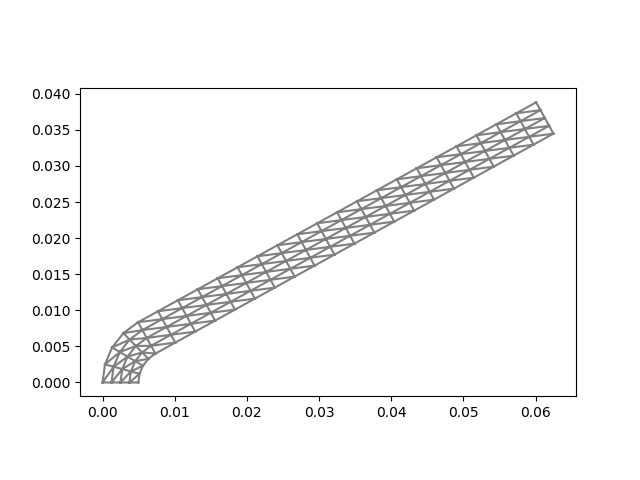

In [12]:
#import libraries
from fenics import *
from ufl import nabla_div 
import numpy as np
import matplotlib.pyplot as plt


mesh = Mesh('Geometry2d.xml')
#mesh = refine(refine(mesh))

%matplotlib notebook
plot(mesh)